In [48]:
%matplotlib notebook

In [109]:
import matplotlib
matplotlib.use('Agg')

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [46]:
import os
import pickle as pkl
import numpy as np
from matplotlib import pyplot as plt

In [7]:
qs = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
cascade_ids = list(range(0, 5))
methods = ['closure', 'tbfs', 'no-order']

In [4]:
result_dir = 'outputs/real_cascade_experiment/cascade_{}/'

In [37]:
rows = []
for q in qs:
    row = {}
    for method in methods:
        row[method] = {}
        for i in cascade_ids:
            # gather count statistics across all casacades,
            try:
                path = os.path.join(result_dir.format(i), method, "{}.pkl".format(q))
                r = pkl.load(open(path, 'rb'))
                
                # initialize
                if len(row[method]) == 0:
                    for key in r.columns:
                        row[method][key] = 0
            except FileNotFoundError:
                print(path, ": not found")
            count = r['n.correct_nodes']['count']
            
            for key in r.columns:
                row[method][key] += r[key]['mean'] * count

            
        row[method]['precision'] = row[method]['n.correct_nodes'] / row[method]['n.pred_nodes']
        row[method]['recall'] = row[method]['n.correct_nodes'] / row[method]['n.true_nodes']
        row[method]['order accuracy'] = row[method]['n.correct_edges'] / row[method]['n.pred_edges']        
    rows.append(row)


In [44]:
measures = ['precision', 'recall', 'order accuracy']

In [45]:
# measure x qs x methods
data = np.zeros((3, len(qs), len(methods)))
for i, (q, row) in enumerate(zip(qs, rows)):
    for j, method in enumerate(methods):
        for k, measure in enumerate(measures):
            data[k, i, j] = row[method][measure]


In [100]:
qs = np.array(qs)
x = np.log2(qs / qs[0])

In [120]:
from plot_utils import make_line_cycle
line_cycle = make_line_cycle()

<IPython.core.display.Javascript object>


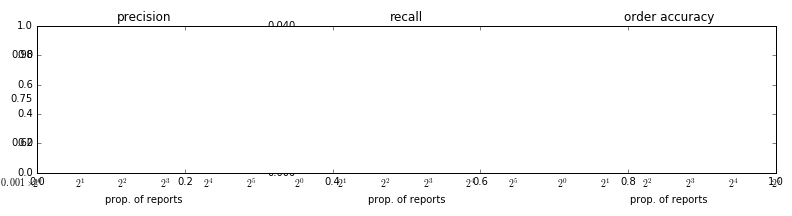

In [117]:
lines = []
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
for k, measure in enumerate(measures):
    ax = axes[k]
    for j, m in enumerate(methods):
        l, = ax.plot(x, data[k,:,j], next(line_cycle), markersize=10)
        if len(lines) < len(methods):
            lines.append(l)
    ax.set_title(measure)
    ax.set_xlabel('prop. of reports')
    max_ticks=5
    ax.yaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    
    xticks = ax.get_xticks()
    labels = list(map(lambda v: "$2^{}$".format(int(v)), xticks))
    ax.set_xticklabels(labels)
    if measure in ['precision', 'order accuracy']:
        ax.set_ylim(0.5, 1.0)
ax.text(0, 0.14, r"$0.001\times$ ", transform=plt.gcf().transFigure)    
plt.tight_layout()
fig.savefig('figs/digg.pdf')


<IPython.core.display.Javascript object>


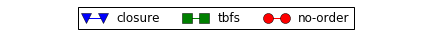

In [118]:
figlegend = plt.figure(figsize=(2 * len(methods), 0.5))
ax = fig.add_subplot(111)

figlegend.legend(lines, methods, 'center', ncol=len(methods))
figlegend.show()
figlegend.savefig('figs/legend.pdf')
